# Делаем прогноз слов рекуррентной сетью

## Прогноз на основе входного `one-hot` вектора

Построим сеть для прогноза следующего слова. В самом простом варианте, нам следует сформировать трехмерный тензор


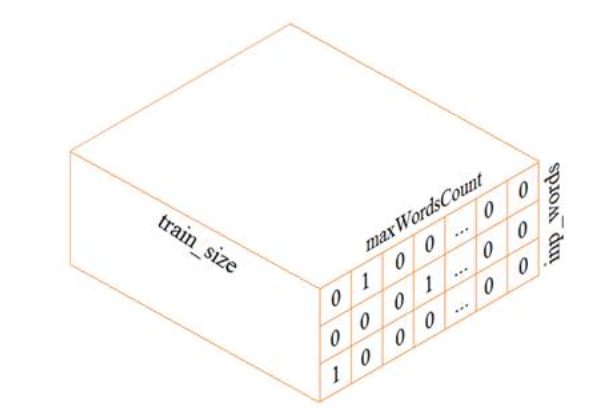

Из текста будем выделять слова целиком (а не отдельные символы). Набор уникальных слов будут составлять наш словарь. Размер этого словаря обозначим через переменную `maxWordsCount`.

Каждое слово, затем, будет кодироваться `one-hot` вектором в соответствии с его номером в словаре:




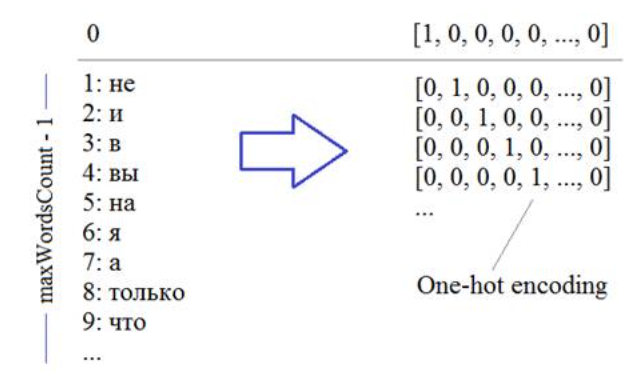

Второй важный параметр – число слов, на основе которых строится прогноз, который определяется переменной `inp_words`.

Cначала загрузим тексты с высказываниями из файла `text.txt`

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical



In [ ]:
# Прочитаем файл с данными в переменную df и изучим их

with open('text.txt', 'r', encoding='utf-8') as df:
    texts = df.read()
    texts = texts.replace('\ufeff', '') # убираем первый невидимый символ

Теперь нам нужно разбить эти высказывания на слова. Для этого воспользуемся уже знакомым инструментом `Tokenizer` и положим, что максимальное число слов будет равно 1000:

In [ ]:
maxWordsCount = 1000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»',
                       lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts([texts])

In [ ]:
# Просматриваем словарь токенизатора
tokenizer.word_index

{'не': 1,
 'и': 2,
 'в': 3,
 'вы': 4,
 'на': 5,
 'я': 6,
 'только': 7,
 'а': 8,
 'все': 9,
 'что': 10,
 'это': 11,
 'если': 12,
 'жизнь': 13,
 'просто': 14,
 'с': 15,
 'никогда': 16,
 'чем': 17,
 'чтобы': 18,
 'у': 19,
 'к': 20,
 'то': 21,
 'себя': 22,
 'больше': 23,
 'всегда': 24,
 'меня': 25,
 'за': 26,
 'вас': 27,
 'мне': 28,
 'от': 29,
 'когда': 30,
 'вам': 31,
 'никому': 32,
 'сделать': 33,
 'есть': 34,
 'жизни': 35,
 'без': 36,
 'быть': 37,
 'но': 38,
 'позитивным': 39,
 'такой': 40,
 'тебя': 41,
 'как': 42,
 'никто': 43,
 'для': 44,
 'много': 45,
 'тем': 46,
 'деньги': 47,
 'своих': 48,
 'денег': 49,
 'ты': 50,
 'день': 51,
 'позитивное': 52,
 'мы': 53,
 'ничего': 54,
 'значит': 55,
 'лучше': 56,
 'надо': 57,
 'так': 58,
 'свою': 59,
 'них': 60,
 'того': 61,
 'позитивно': 62,
 'которые': 63,
 'мечты': 64,
 'нужно': 65,
 'тебе': 66,
 'опасно': 67,
 'равно': 68,
 'ни': 69,
 'нет': 70,
 'успеха': 71,
 'же': 72,
 'сама': 73,
 'стоит': 74,
 'болезней': 75,
 'энергию': 76,
 'себе': 77

Мы разбили текст на слова и для примера выведем их начальный список:

In [ ]:
dist = list(tokenizer.word_counts.items())
print(dist[:10])

[('я', 21), ('притягиваю', 1), ('только', 21), ('плохое', 1), ('кому', 2), ('нужен', 2), ('с', 12), ('такой', 5), ('внешностью', 2), ('не', 91)]


Здесь отображаются кортежи со словом и его частотой встречаемости в тексте.

Далее, мы преобразуем текст в последовательность чисел в соответствии с полученным словарем. Для этого используется специальный метод `texts_to_sequences()` класса `Tokenizer`:

In [ ]:
data = tokenizer.texts_to_sequences([texts])

На выходе получим массив чисел объекта `numpy`:

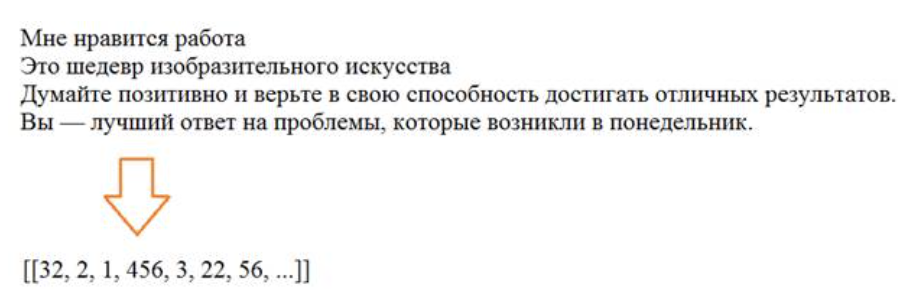



Осталось закодировать числа массива data в `one-hot` векторы. Для этого мы воспользуемся методом `to_categorical` пакета `Keras`:

In [ ]:
res = to_categorical(data[0], num_classes=maxWordsCount)
res.shape

(1667, 1000)

На выходе получим двумерную матрицу, состоящую из `One-hot` векторов.

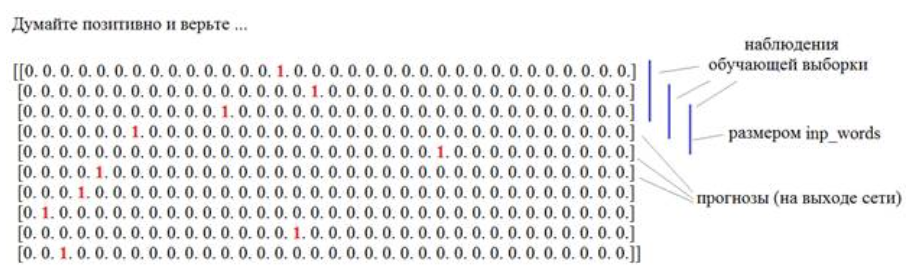

In [ ]:
res[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Затем, из этой матрицы сформируем тензор обучающей выборки и соответствующий набор выходных значений. Для начала вычислим размер обучающего множества и сформируем входной тензор и прогнозные значения


In [ ]:
inp_words = 3 #количесвто слов в последовательности которые будут признаками первые три слова х четвёртое у
n = res.shape[0]-inp_words

X = np.array([res[i:i+inp_words, :] for i in range(n)])
Y = res[inp_words:]

Обучающая выборка и требуемые выходные значения готовы. Осталось создать модель рекуррентной сети. Мы возьмем простую RNN с числом нейронов скрытого слоя 32 и `maxWordsCount` нейронами на выходе с функцией активации `softmax`:

In [ ]:
model = keras.Sequential([
    Input((inp_words, maxWordsCount)),
    SimpleRNN(32, activation='tanh'),
    Dense(maxWordsCount, activation='softmax') #maxWordsCount количество выходных нейронов у нас 1000 так как словарь размером 1000
])
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │          33,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │          33,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,056 (258.03 KB)

 Trainable params: 66,056 (258.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Запускаем процесс обучения:
history = model.fit(X, Y, validation_split=0.15, batch_size=32, epochs=50)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0058 - loss: 6.9040 - val_accuracy: 0.0280 - val_loss: 6.9023
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0668 - loss: 6.7769 - val_accuracy: 0.0360 - val_loss: 7.1468
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0577 - loss: 6.1520 - val_accuracy: 0.0360 - val_loss: 7.6980
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0630 - loss: 5.9702 - val_accuracy: 0.0360 - val_loss: 7.7525
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0653 - loss: 5.9296 - val_accuracy: 0.0360 - val_loss: 7.7992
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0570 - loss: 5.8842 - val_accuracy: 0.0360 - val_loss: 7.9036
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0516 - loss: 5.8689 - val_accuracy: 0.0360 - val_loss: 8.0478
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0546 - loss: 5.7701 - val_accuracy: 0.0360 - val_loss

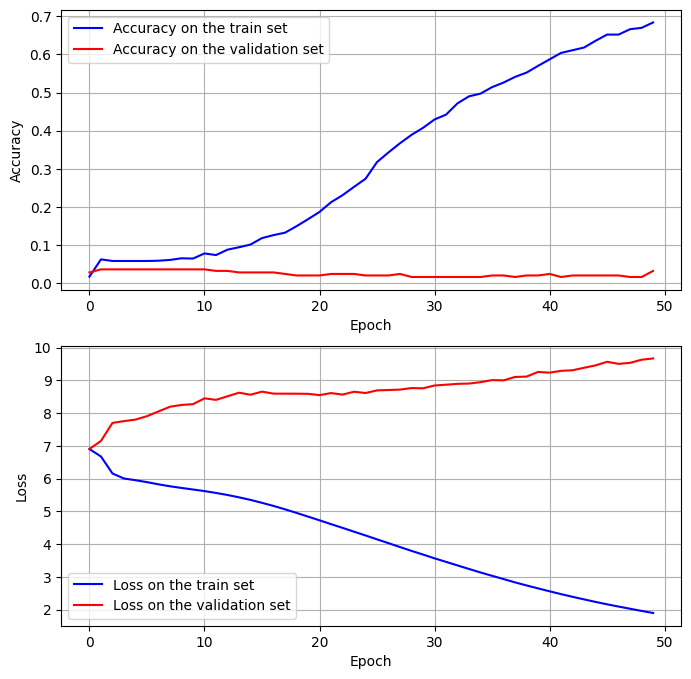

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(history.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(history.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Посмотрим, что у нас получилось. Запишем функцию для формирования текста из спрогнозированных слов:


In [ ]:
def buildPhrase(texts, str_len = 20):
  res = texts
  data = tokenizer.texts_to_sequences([texts])[0]
  for i in range(str_len):
    x = to_categorical(data[i: i+inp_words], num_classes=maxWordsCount) # преобразуем в One-Hot-encoding
    inp = x.reshape(1, inp_words, maxWordsCount)

    pred = model.predict( inp ) # предсказываем OHE четвертого символа
    indx = pred.argmax(axis=1)[0]
    data.append(indx)

    res += " " + tokenizer.index_word[indx] # дописываем строку

  return res

In [ ]:
# Вызовем функцию с тремя первыми словами:
forecast = buildPhrase("позитив добавляет годы")
forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'позитив добавляет годы свои вашей жизни ожидания к их ради оптимизмом это хочешь позитиве вы оно у и к два все оптимизмом месяц'

Выглядит достаточно сумбурно. Такой результат связан с очень маленькой обучающей выборкой. По идее, здесь нужно взять какую-нибудь большую книгу и прогнать ее через сеть. Но наша цель - показать общий принцип использования рекуррентных сетей для прогнозирования слов в последовательности.

## Embedding-слой

В предыдущей реализации на основе `one-hot` вектора есть один существенный недостаток: входной тензор занимает в памяти очень много места.

Поэтому специалисты по нейронным сетям предложили альтернативный подход – использование специального входного слоя `Embedding`.

В чем его суть? Когда мы подаем вектор с единицей на определенной позиции, то у нас, фактически, используются только связи для этого одного входа, остальные умножаются на 0 и формируют нулевые суммы на всех остальных нейронах скрытого слоя:

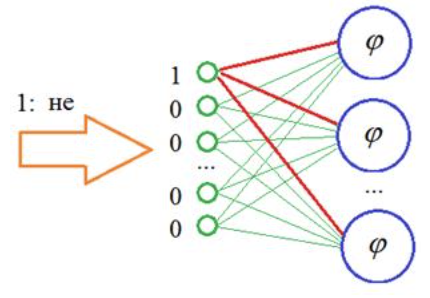

И отсюда хорошо видно, что если передавать на вход не такие расширенные векторы, а последовательность с порядковыми номерами слов в словаре:

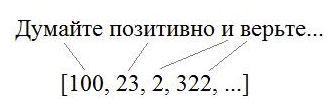

то на входе нейронной сети можно реализовать простой алгоритм, который бы подавал 1 на нейрон с соответствующим номером этого слова, а остальные суммы приравнивались бы нулю. В итоге, мы существенно экономим память при хранении обучающей выборки, а результат получаем тот же самый. Именно такую операцию и выполняет `Embedding` слой. На выходах его слоя формируются выходные значения, равные весам связей для переданной 1:

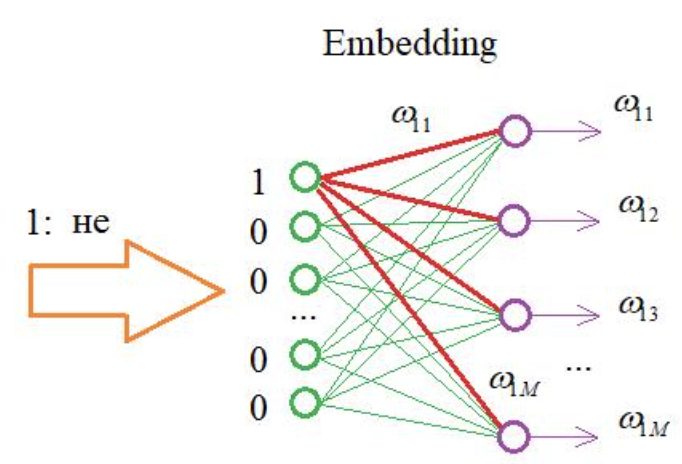

Далее, эти значения весов подаются уже на следующий слой нейронной сети.

В `Keras` такой слой можно создать с помощью одноименного класса:

`keras.layers.Embedding(input_dim, output_dim, …, input_length)`

* `input_dim` – число слов в словаре;
* `output_dim` – число выходов в полносвязном `Embedding`-слое;
* `input_length` – размер входного вектора.

Есть и другие параметры, подробно о них можно почитать на странице документации по ссылке: https://ru-keras.com/embedding-layers/


Этот слой можно создавать только как входной.

В нашем случае мы его определим с 64 выходами в `Embedding`-слое. В качестве входной обучающей выборки мы теперь можем использовать одномерный массив. А выходные значения остаются прежними – двумерным массивом из `One-hot` векторов, так как у нас на выходе 1000 нейронов.


In [ ]:
data = tokenizer.texts_to_sequences([texts])
res = np.array( data[0] )

inp_words = 3
n = res.shape[0] - inp_words

X = np.array([res[i:i + inp_words] for i in range(n)])
Y = to_categorical(res[inp_words:], num_classes=maxWordsCount)

Далее, абсолютно также проводим обучение и немного модифицируем функцию `buildPhrase`.

In [ ]:
model = keras.Sequential([
    Embedding(maxWordsCount, 64, input_length = inp_words),
    SimpleRNN(32, activation='tanh'),
    Dense(maxWordsCount, activation='softmax')
])
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X, Y, validation_split=0.15,batch_size=32, epochs=50)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0079 - loss: 6.9032 - val_accuracy: 0.0360 - val_loss: 6.9000
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0552 - loss: 6.7240 - val_accuracy: 0.0360 - val_loss: 7.1994
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0466 - loss: 6.0914 - val_accuracy: 0.0360 - val_loss: 7.5861
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0502 - loss: 5.9491 - val_accuracy: 0.0360 - val_loss: 7.6632
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0621 - loss: 5.8143 - val_accuracy: 0.0360 - val_loss: 7.7091
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0597 - loss: 5.7478 - val_accuracy: 0.0360 - val_loss: 7.8211
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0627 - loss: 5.6991 - val_accuracy: 0.0360 - val_loss: 7.8677
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0644 - loss: 5.5755 - val_accuracy: 0.0320 - val_loss

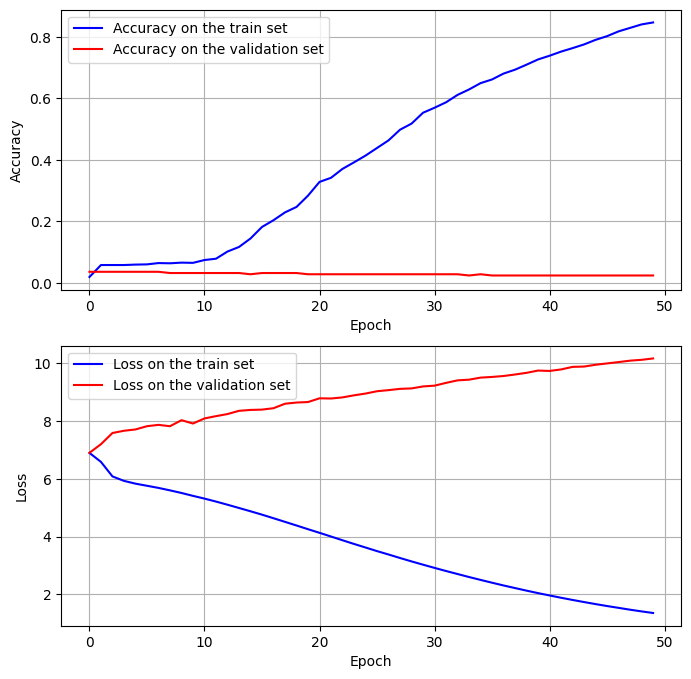

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(history.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(history.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def buildPhrase(texts, str_len=20):
    res = texts
    data = tokenizer.texts_to_sequences([texts])[0]
    for i in range(str_len):
        x = data[i: i + inp_words]
        inp = np.expand_dims(x, axis=0)

        pred = model.predict(inp)
        indx = pred.argmax(axis=1)[0]
        data.append(indx)

        res += " " + tokenizer.index_word[indx]  # дописываем строку

    return res

In [ ]:
forecast = buildPhrase("позитив добавляет годы")
forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'позитив добавляет годы свои вашей жизни ожидания к их ради весну должен хочешь по не доведет у а честные не просто себя а'

## Задание для самостоятельного выполнения